### Data preparation


In [1]:
from scipy.io import loadmat
from matplotlib.pyplot import (
    figure,
    subplot,
    plot,
    xlabel,
    ylabel,
    title,
    yticks,
    show,
    legend,
    imshow,
    cm,
)
import scipy.linalg as linalg
from scipy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import xlrd
import pandas as pd
from pandas.plotting import scatter_matrix

In [2]:
file_path = r"C:\Users\Dell\Desktop\Git Hub\Machine-Learning-report1\MAIN_Movies_DS.xls"
doc = xlrd.open_workbook(file_path).sheet_by_index(0)

In [3]:
# Extract attribute names
attributeNames = doc.row_values(0, 2, 10)

# Extract MPAA names to python list, then encode with integers (dict)
mpaa = doc.col_values(3, 2, 636)
mpaa_name = sorted(set(mpaa))  # set because it deletes the duplicates
mpaaDict = dict(zip(mpaa_name, range(5)))

# Extract names to python list, then encode with integers (dict)
# the column Genre was moved to this position in excel
genre = doc.col_values(2, 2, 636)
genre_name = sorted(set(genre))
genreDict = dict(zip(genre_name, range(18)))

title = doc.col_values(1, 2, 636)
title_name = sorted(set(title))
titleDict = dict(zip(title_name, range(627)))

rating = doc.col_values(8, 2, 636)
rating_name = sorted(set(rating))
ratDict = dict(zip(rating_name, range(627)))

In [4]:
# Extract vector y, convert to NumPy array
y_mpaa = np.array([mpaaDict[value] for value in mpaa])
y_genre = np.array([genreDict[value] for value in genre])
y_title = np.array([titleDict[value] for value in title])
y_rat = np.array([ratDict[value] for value in rating])

In [5]:
# Create a dataframe from the data
data = pd.DataFrame(
    {
        "MPAA_Rating": y_mpaa,
        "genre": y_genre,
        "title": y_title,
        "Budget": doc.col_values(4, 2, 636),
        "Gross": doc.col_values(5, 2, 636),
        "release_date": doc.col_values(6, 2, 636),
        "runtime": doc.col_values(7, 2, 636),
        "rating": doc.col_values(8, 2, 636),
        "rating_count": doc.col_values(9, 2, 636),
    }
)

In [6]:
# DATA CLEANING
# Remove duplicates based on the "title" column
data = data.drop_duplicates(subset="title", keep="first")
data.dropna(inplace=True)

In [7]:
data

,MPAA_Rating,genre,title,Budget,Gross,release_date,runtime,rating,rating_count
0,1,3,129,7500000.0,145793296.0,32855.0,99.0,7.4,91075.0
1,1,4,583,13000000.0,71079915.0,32717.0,100.0,7.2,91415.0
2,3,15,63,14000000.0,161001698.0,32862.0,145.0,7.2,91415.0
3,1,5,155,15000000.0,84431625.0,32619.0,107.0,7.5,101702.0
4,1,6,586,15000000.0,79258538.0,32736.0,100.0,7.0,77659.0
...,...,...,...,...,...,...,...,...,...
629,2,0,318,250000000.0,765199095.0,44477.0,163.0,7.3,323556.0
630,2,10,624,55000000.0,106457.0,44512.0,115.0,7.5,82101.0
631,2,0,594,110000000.0,212500000.0,44470.0,157.0,6.0,180165.0
632,2,3,338,17000000.0,115400000.0,41187.0,112.0,4.4,276.0


## Regression part a


### 1:

Explain what variable is predicted based on which other variables and what
you hope to accomplish by the regression. Mention your feature transformation
choices such as one-of-K coding. Since we will use regularization momentarily,
apply a feature transformation to your data matrix X such that each column
has mean 0 and standard deviation 1.


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

That's a line to take the dataset saved from another file


ENCODING


In [9]:
## ONE OUT OF K ENCODING
columns_to_encode = ["MPAA_Rating", "genre"]

# Apply one-hot encoding using get_dummies with dtype=int
data_encoded = pd.get_dummies(
    data, columns=columns_to_encode, prefix=columns_to_encode, dtype=int
)

# Display the updated DataFrame with one-hot encoded columns using 0 and 1
print(data_encoded.head())

   title      Budget        Gross  release_date  runtime  rating  \
0    129   7500000.0  145793296.0       32855.0     99.0     7.4   
1    583  13000000.0   71079915.0       32717.0    100.0     7.2   
2     63  14000000.0  161001698.0       32862.0    145.0     7.2   
3    155  15000000.0   84431625.0       32619.0    107.0     7.5   
4    586  15000000.0   79258538.0       32736.0    100.0     7.0   

   rating_count  MPAA_Rating_0  MPAA_Rating_1  MPAA_Rating_2  ...  genre_7  \
0       91075.0              0              1              0  ...        0   
1       91415.0              0              1              0  ...        0   
2       91415.0              0              0              0  ...        0   
3      101702.0              0              1              0  ...        0   
4       77659.0              0              1              0  ...        0   

   genre_8  genre_9  genre_10  genre_11  genre_12  genre_13  genre_14  \
0        0        0         0         0         0

STANDARDIZING


In [20]:
columns_to_standardize = [
    "Budget",
    "Gross",
    "release_date",
    "runtime",
    "rating",
    "rating_count",
]

# # Create a StandardScaler instance with custom mean and standard deviation
# # custom_scaler_std = StandardScaler(with_mean=True, with_std=True)


# # Fit and transform the selected columns using the custom scaler
# # data_encoded[columns_to_standardize] = custom_scaler_std.fit_transform(
# #     data_encoded[columns_to_standardize]
# # )

custom_scaler = StandardScaler()
data_encoded[columns_to_standardize] = pd.DataFrame(
    custom_scaler.fit_transform(data[columns_to_standardize]),
    columns=columns_to_standardize,
)

# # Display the updated DataFrame
print(data_encoded)

       Budget     Gross  release_date   runtime    rating  rating_count  \
0   -1.285567 -0.857075     -1.647076 -0.894319  0.512297     -0.818831   
1   -1.204122 -1.078317     -1.688438 -0.849603  0.282489     -0.817722   
2   -1.189314 -0.812040     -1.644978  1.162614  0.282489     -0.817722   
3   -1.174506 -1.038780     -1.717810 -0.536591  0.627202     -0.784183   
4   -1.174506 -1.054099     -1.682743 -0.849603  0.052680     -0.862572   
..        ...       ...           ...       ...       ...           ...   
620  1.046720 -0.103737      1.840458  1.609774  1.316628      0.529207   
622 -0.582179 -1.288484      1.846753 -0.178864  0.627202     -0.848089   
623  0.232270 -0.659543      1.834164  1.699205 -1.096364     -0.528366   
624 -1.144889 -0.947076      0.850186 -0.313012 -2.934834     -1.114868   
625 -1.100465 -1.119419      0.132657 -0.626023 -2.819929     -1.114979   

     MPAA_Rating_0  MPAA_Rating_1  MPAA_Rating_2  MPAA_Rating_3  ...  genre_7  \
0                0

1. Split your data into features (independent variables) and the target variable (Gross)


In [21]:
# data_encoded = data_encoded.drop(columns="title")
data_encoded.dropna(inplace=True)
X_std = data_encoded.drop(columns="Gross")  # Features (indipendent variables)
y_std = data_encoded["Gross"]  # Target variable (dipendent variable)

2. Define a range of values for the regularization parameter λ (alpha) that you want to test.

These values were decided by trying different combinations of them and how the plots were


In [12]:
lambdas = np.arange(0, 300, 1, dtype="float")

3. Perform 10-fold cross-validation with Ridge regression for each value of λ


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_std, y_std, random_state=42, test_size=0.3
)

In [23]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

432
186
432
186


In [24]:
import warnings

# Desactivar todos los warnings
warnings.filterwarnings("ignore")

errors = []
errors_r2 = []
ridge_results = {}
best_error = 1

best_lambda = None

for lambda_i in lambdas:
    model = Ridge(alpha=lambda_i)

    # 10 fold cross validation

    scores = cross_val_score(model, X_train, y_train, cv=10)

    mean_score = scores.mean()

    # generalization error for lambda_i

    gen_err = 1 - mean_score

    errors.append(gen_err)

    # Ridge Model Fernando
    lr = Ridge(alpha=lambda_i)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    ridge_scores = cross_val_score(
        lr, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    ridge_mse = -np.mean(ridge_scores)
    ridge_results[lambda_i] = ridge_mse

    if gen_err < best_error:
        best_error = gen_err  # update the lowest generalization error
        best_lambda = lambda_i  # update the best lambda

    y_pred = cross_val_predict(model, X_test, y_test, cv=10)  # Model previsions
    r_2 = r2_score(y_test, y_pred)
    # number of misclassified observations
    errors_r2.append(r_2)
print("R2 errors: {errors_r2}")
print(f"ridge results:{ridge_results}")
print(f"best error = {best_error}, best lambda = {best_lambda}")

R2 errors: {errors_r2}
ridge results:{0.0: 0.5159964911654379, 1.0: 0.4852458347777208, 2.0: 0.4828360540612101, 3.0: 0.48121062700569794, 4.0: 0.48003713220723904, 5.0: 0.4791513040457702, 6.0: 0.4784602711240412, 7.0: 0.4779070981701534, 8.0: 0.4774549035480945, 9.0: 0.47707880000195413, 10.0: 0.4767614456039464, 11.0: 0.4764904332982905, 12.0: 0.4762566862304983, 13.0: 0.4760534340812576, 14.0: 0.4758755398202762, 15.0: 0.47571904539278903, 16.0: 0.4755808582910957, 17.0: 0.4754585311063414, 18.0: 0.4753501038065756, 19.0: 0.47525398915687145, 20.0: 0.4751688883265725, 21.0: 0.4750937279477321, 22.0: 0.4750276126315698, 23.0: 0.47496978876700957, 24.0: 0.4749196166502191, 25.0: 0.4748765488325257, 26.0: 0.47484011315627733, 27.0: 0.4748098993577362, 28.0: 0.47478554840764486, 29.0: 0.47476674396999224, 30.0: 0.47475320551216493, 31.0: 0.4747446827117912, 32.0: 0.4747409508886601, 33.0: 0.4747418072522045, 34.0: 0.47474706780180015, 35.0: 0.47475656475264544, 36.0: 0.4747701443871216

In [27]:
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_predict, KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score


# Create a Ridge model
ridge_model = Ridge()

# Define the parameter grid
param_grid = {"alpha": lambdas}

# Use GridSearchCV for cross-validated grid search
grid_search = GridSearchCV(
    ridge_model, param_grid, cv=10, scoring="neg_mean_squared_error"
)
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_alpha = grid_search.best_params_["alpha"]
best_model = grid_search.best_estimator_

# Print the results
print(f"Best alpha: {best_alpha}")
print(f"Best MSE: {-grid_search.best_score_}")

# Use the best model for predictions
y_pred = cross_val_predict(best_model, X_test, y_test, cv=10)
r_2 = r2_score(y_test, y_pred)
print(f"R2 error: {r_2}")

Best alpha: 19.0
Best MSE: 0.47085120010257064
R2 error: 0.5273431581690784


Ridge results:  {0.0: 0.5159964911654379, 1.0: 0.4852458347777208, 2.0: 0.4828360540612101, 3.0: 0.48121062700569794, 4.0: 0.48003713220723904, 5.0: 0.4791513040457702, 6.0: 0.4784602711240412, 7.0: 0.4779070981701534, 8.0: 0.4774549035480945, 9.0: 0.47707880000195413, 10.0: 0.4767614456039464, 11.0: 0.4764904332982905, 12.0: 0.4762566862304983, 13.0: 0.4760534340812576, 14.0: 0.4758755398202762, 15.0: 0.47571904539278903, 16.0: 0.4755808582910957, 17.0: 0.4754585311063414, 18.0: 0.4753501038065756, 19.0: 0.47525398915687145, 20.0: 0.4751688883265725, 21.0: 0.4750937279477321, 22.0: 0.4750276126315698, 23.0: 0.47496978876700957, 24.0: 0.4749196166502191, 25.0: 0.4748765488325257, 26.0: 0.47484011315627733, 27.0: 0.4748098993577362, 28.0: 0.47478554840764486, 29.0: 0.47476674396999224, 30.0: 0.47475320551216493, 31.0: 0.4747446827117912, 32.0: 0.4747409508886601, 33.0: 0.4747418072522045, 34.0: 0.47474706780180015, 35.0: 0.47475656475264544, 36.0: 0.4747701443871216, 37.0: 0.47478766525

<Figure size 800x500 with 0 Axes>

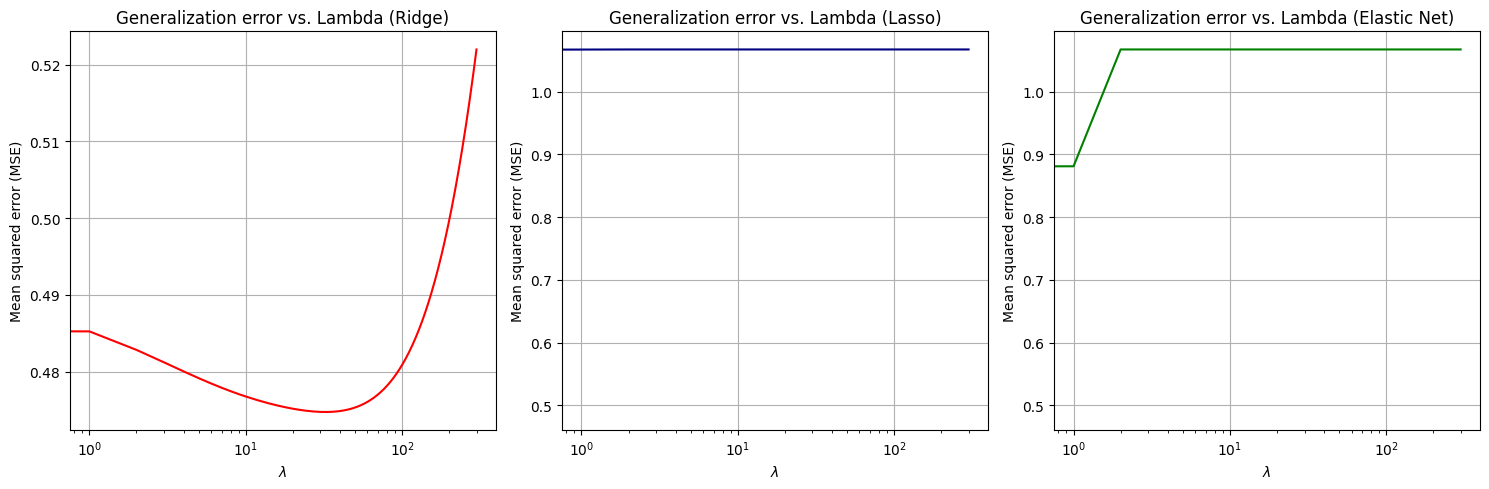

In [29]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Diccionarios para almacenar los resultados de cada modelo
ridge_results = {}
lasso_results = {}
elastic_net_results = {}

# Itera a través de los valores de lambda y realiza la validación cruzada
# Para cada lambda se obtiene un resultado el qual se almacena en los diccionarios declarados arriba.
# Tres tipos de cross validation diferentes.
for lambda_val in lambdas:
    # Ridge Model
    ridge_model = Ridge(alpha=lambda_val)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    ridge_scores = cross_val_score(
        ridge_model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    ridge_mse = -np.mean(ridge_scores)
    ridge_results[lambda_val] = ridge_mse

    # Lasso Model
    lasso_model = Lasso(alpha=lambda_val)
    lasso_scores = cross_val_score(
        lasso_model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    lasso_mse = -np.mean(lasso_scores)
    lasso_results[lambda_val] = lasso_mse

    # Elastic Net Model
    elastic_net_model = ElasticNet(
        alpha=lambda_val, l1_ratio=0.5
    )  # l1_ratio = 0.5 para balancear L1 y L2
    elastic_net_scores = cross_val_score(
        elastic_net_model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    elastic_net_mse = -np.mean(elastic_net_scores)
    elastic_net_results[lambda_val] = elastic_net_mse


print("Ridge results: ", ridge_results)
print("Lasso results: ", lasso_results)
print("ElasticNet results: ", elastic_net_results)

# Crear una figura con una fila y tres columnas
plt.figure(figsize=(8, 5))
plt.subplots(1, 3, figsize=(15, 5))

# Graficar los resultados para Ridge
plt.subplot(1, 3, 1)
plt.plot(
    lambdas, list(ridge_results.values()), linestyle="-", color="red", label="Ridge"
)
plt.xlabel("$λ$")
plt.ylabel("Mean squared error (MSE)")
plt.title("Generalization error vs. Lambda (Ridge)")
plt.xscale("log")
plt.grid(True)

# Graficar los resultados para Lasso
plt.subplot(1, 3, 2)
plt.plot(
    lambdas, list(lasso_results.values()), linestyle="-", color="navy", label="Lasso"
)
plt.xlabel("$λ$")
plt.ylabel("Mean squared error (MSE)")
plt.title("Generalization error vs. Lambda (Lasso)")
plt.xscale("log")
plt.grid(True)

# Graficar los resultados para Elastic Net
plt.subplot(1, 3, 3)
plt.plot(
    lambdas,
    list(elastic_net_results.values()),
    linestyle="-",
    color="g",
    label="Elastic Net",
)
plt.xlabel("$λ$")
plt.ylabel("Mean squared error (MSE)")
plt.title("Generalization error vs. Lambda (Elastic Net)")
plt.xscale("log")
plt.grid(True)

# Ajustar los subplots para evitar solapamiento
plt.tight_layout()

# Guardar la figura como un archivo PDF
# plt.savefig("combined_regression_results.pdf")

# Mostrar la figura en la pantalla
plt.show()

In [30]:
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = ridge_model.predict(X_test)

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)

# Calculate R2
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.44627168242382925
MSE: 0.4153669641472934
RMSE: 0.6444896928169553
R2: 0.526106595747249


4. Find the λ that gives the lowest generalization error


Values of coefficients are the weigths for each feature and intercept is the bias term
$$y=(biasterm) + weigths*(features)$$


In [79]:
# Create and train a Ridge regression model
model = Ridge(alpha=best_lambda)  # Use the best_alpha value you've determined
model.fit(X_std, y_std)  # X is your feature matrix, y is your target variable

# Access the coefficients
coefficients = model.coef_  # Coefficients (weights)
intercept = model.intercept_  # Intercept (bias term)

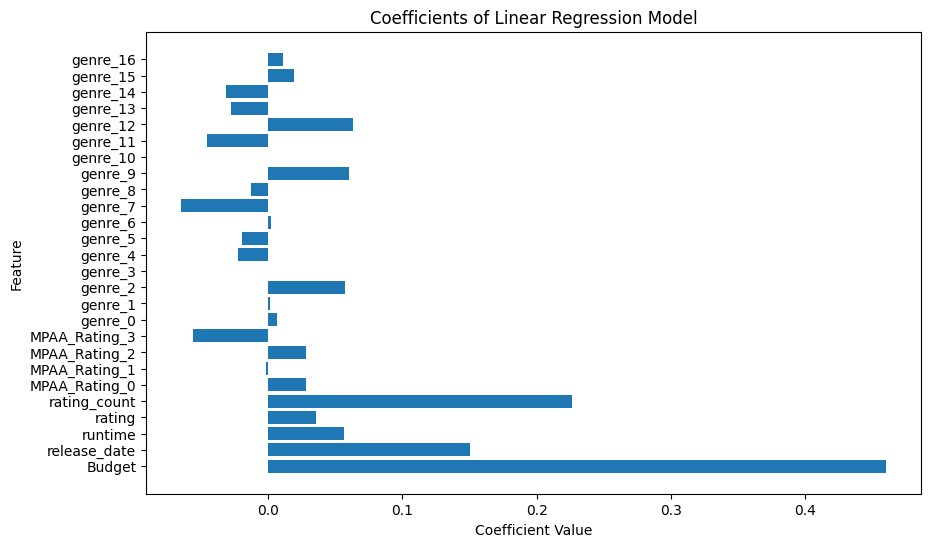

In [80]:
feature_names = X_std.columns
# Creare un grafico a barre per visualizzare i coefficienti
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Coefficients of Linear Regression Model")
plt.show()

In [82]:
print(f"y = {intercept} + coefficients * weigths")

y = -0.002258479326901544 + coefficients * weigths


This is the plot as 14.2 in the book


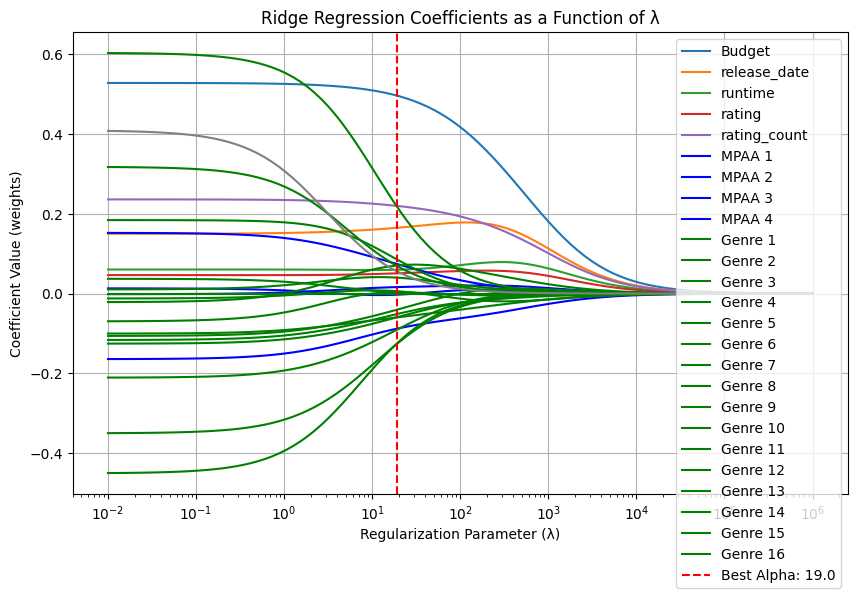

In [77]:
coefficients = []
lambdas1 = np.logspace(-2, 6, 100, base=10)

for alpha in lambdas1:
    # Create and fit a Ridge regression model
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)  # Use your transformed data

    # Get the coefficients for this λ
    coef = model.coef_
    coefficients.append(coef)

# Convert coefficients to a NumPy array
coefficients = np.array(coefficients)

# Create a plot to visualize the coefficients
plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    if 0 <= i <= 4:
        plt.semilogx(lambdas1, coefficients[:, i], label=f"{X_std.columns[i]}")
    elif 5 <= i <= 8:
        plt.semilogx(
            lambdas1,
            coefficients[:, i],
            color="blue",
            linestyle="-",
            label=f"MPAA {i-4}",
        )
    elif 9 <= i <= 24:
        plt.semilogx(
            lambdas1,
            coefficients[:, i],
            color="green",
            linestyle="-",
            label=f"Genre {i-8}",
        )
    else:
        plt.semilogx(
            lambdas1, coefficients[:, i], color="gray"
        )  # Plot features outside the range in gray

# Add a vertical line for the best_alpha
plt.axvline(x=best_alpha, color="r", linestyle="--", label=f"Best Alpha: {best_alpha}")

plt.title("Ridge Regression Coefficients as a Function of λ")
plt.xlabel("Regularization Parameter (λ)")
plt.ylabel("Coefficient Value (weights)")
plt.legend()

plt.grid()
plt.show()

## Regression part b


In this section, we will compare three models: the regularized
linear regression model from the previous section, an artificial neural network (ANN) and a baseline.

We are interested in two questions:

- Is one model better than the other?
- Is either model better than a trivial baseline?.

We will attempt to answer
these questions with two-level cross-validation.


### 1 Implement two-level cross-validation

(see algorithm 6 of the lecture notes). We will use 2-level cross-validation to compare the models with K1 = K2 = 10 folds.

As a baseline model, we will apply a linear regression model with no features, i.e. it computes the mean of y on the training data, and use this value to predict y on the test data.

Make sure you can fit an ANN model to the data.

As complexity-controlling parameter for the ANN, we will use the number of hidden units5 h.
Based on a few test-runs, select a reasonable range of values for h (which should include h = 1), and describe the range of values you will use for h and λ.


The baseline model is a simple linear regression model that computes the mean of the target variable (y) on the training data and uses this mean value to predict y on the test data.


In [88]:
import torch
from toolbox_functions import train_neural_net
from sklearn import model_selection

Model for ANN analysis


In [142]:
# Parameters for Neural Network
n_hidden_units_range = range(1, 6)  # Testing values from 1 to 10
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 10000
N, M = X_std.shape  # Use the standardized X

dropout_rate = 0.5


def model_ANN(n_hidden_units):
    return torch.nn.Sequential(
        torch.nn.Linear(M, n_hidden_units),  # M features to n_hidden_units
        torch.nn.Sigmoid(),  # 1st transfer function,
        torch.nn.Linear(n_hidden_units, 1),  # n_hidden_units to 1 output neuron
        # no final tranfer function, i.e. "linear output"
    )


loss_fn = torch.nn.MSELoss()

In [143]:
# Define the number of folds for outer and inner cross-validation
outer_folds = 5
inner_folds = 10

# Initialize objects for outer cross-validation
outer_cv = model_selection.KFold(n_splits=outer_folds, shuffle=True, random_state=42)

# List to store the scores of outer cross-validation
outer_scores = []

for k, (train_index, test_index) in enumerate(outer_cv.split(X_std)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, outer_folds))

    ## INDEX EXTRACTION
    # print("Train Index Before Extraction: ", train_index)
    X_par = X_std.iloc[train_index]
    y_par = y_std.iloc[train_index].to_numpy()

    # print("Test Index Before Extraction: ", test_index)
    X_test = X_std.iloc[test_index]
    y_test = y_std.iloc[test_index].to_numpy()

    ## BASELINE NO LAMBDA NO FEATURES
    # Calculate the mean of y in the training data
    y_mean = np.mean(y_par)

    # Create an array of predicted values using the mean
    y_pred_baseline = np.full(y_test.shape, y_mean)

    # Calculate the mean squared error (MSE) for the baseline model
    mse_baseline = ((y_pred_baseline - y_test) ** 2).mean()

    # Print or store the MSE for the baseline model
    print(f"Baseline MSE: {mse_baseline}")

    ## RIDGE REGRESSION
    lambdas = np.arange(1, 200, 1, dtype="float")

    # errors contains generalization error for each lambda
    errors_ridge = []
    best_error_lambda_i = 1
    best_lambda_i_ridge = None

    # RIDGE REGRESSION AS BEFORE
    for lambda_i in lambdas:
        ridge_model = Ridge(alpha=lambda_i)

        # 10 fold cross validation
        scores = cross_val_score(ridge_model, X_par, y_par, cv=inner_folds)
        mean_score = scores.mean()

        # generalization error for lambda_i
        gen_err_lambda_i_ridge = 1 - mean_score

        errors_ridge.append(gen_err_lambda_i_ridge)

        if gen_err_lambda_i_ridge < best_error_lambda_i:
            best_error_lambda_i = (
                gen_err_lambda_i_ridge  # update the lowest generalization error
            )
            best_lambda_i_ridge = lambda_i  # update the best lambda

    # print(errors_ridge)
    print(
        f"Ridge Regression - Best error: {best_error_lambda_i}, Best lambda: {best_lambda_i_ridge}"
    )
    ## ANN
    # Some parameters for Neural Network are defined before the loop
    errors_NN = []
    # Convert training and test set for current CV fold, convert to tensors
    X_par_NN = torch.Tensor(X_par.values)
    y_par_NN = torch.Tensor(y_par)
    X_test_NN = torch.Tensor(X_test.values)
    y_test_NN = torch.Tensor(y_test)

    for n_hidden_units in n_hidden_units_range:
        print(f"\nn_hidden_units: {n_hidden_units}")
        net, final_loss, learning_curve = train_neural_net(
            lambda: model_ANN(n_hidden_units),
            loss_fn,
            X=X_par_NN,
            y=y_par_NN,
            n_replicates=n_replicates,
            max_iter=max_iter,
            tolerance=1e-20,
        )

        # Determine estimated class labels for test set
        y_test_est = net(X_test_NN)

        # Determine errors and errors
        se = (y_test_est.detach().numpy() - y_test) ** 2  # squared error
        mse_NN = np.mean(se)  # mean
        errors_NN.append(mse_NN)  # store error rate for the current CV fold

        print("\n\tBest loss: {}\n".format(final_loss))


Crossvalidation fold: 1/5
Baseline MSE: 1.10436780138053
Ridge Regression - Best error: 0.701133568555798, Best lambda: 133.0

n_hidden_units: 1

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.98003435	3.0409458e-07
		Final loss:
		1219	0.9799896	0.0

	Best loss: 0.9799895882606506


n_hidden_units: 2

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.9806417	1.0940615e-06
		2000	0.98010975	1.8244273e-07
		Final loss:
		2186	0.9800784	0.0

	Best loss: 0.980078399181366


n_hidden_units: 3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.9801316	9.1219266e-07
		Final loss:
		1310	0.9800091	0.0

	Best loss: 0.9800090789794922


n_hidden_units: 4

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		750	0.9800404	0.0

	Best loss: 0.9800403714179993


n_hidden_units: 5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.9801214	3.6488106e-07
		Final loss:
		1231	0.98007905	0.0

	Best loss: 0.9800790548324585


Crossvalidation fold: 2/5
Baseline MSE: 1.0932739691424929
Ridge Regression 

In [144]:
# Define the number of folds for outer and inner cross-validation
outer_folds = 10
inner_folds = 10

# Initialize objects for outer cross-validation
outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=42)

# Lists to store the results for each fold
fold_numbers = []
baseline_mse_values = []
ridge_best_errors = []
ridge_best_lambdas = []
ridge_test_errors = []
ann_n_hidden_units = []
ann_best_losses = []
ann_test_errors = []

# Loop over each fold
for k, (train_index, test_index) in enumerate(outer_cv.split(X_std)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, outer_folds))

    ## INDEX EXTRACTION
    X_par = X_std.iloc[train_index]
    y_par = y_std.iloc[train_index].to_numpy()
    X_test = X_std.iloc[test_index]
    y_test = y_std.iloc[test_index].to_numpy()

    ## BASELINE NO LAMBDA NO FEATURES
    y_mean = np.mean(y_par)
    y_pred_baseline = np.full(y_test.shape, y_mean)
    mse_baseline = ((y_pred_baseline - y_test) ** 2).mean()

    # Store the results for the baseline model
    fold_numbers.append(k + 1)
    baseline_mse_values.append(mse_baseline)

    ## RIDGE REGRESSION
    lambdas = np.arange(1, 200, 1, dtype="float")
    errors_ridge = []
    best_error_lambda_i = 1
    best_lambda_i_ridge = None

    for lambda_i in lambdas:
        ridge_model = Ridge(alpha=lambda_i)
        scores = cross_val_score(ridge_model, X_par, y_par, cv=inner_folds)
        mean_score = scores.mean()
        gen_err_lambda_i_ridge = 1 - mean_score
        errors_ridge.append(gen_err_lambda_i_ridge)

        if gen_err_lambda_i_ridge < best_error_lambda_i:
            best_error_lambda_i = gen_err_lambda_i_ridge
            best_lambda_i_ridge = lambda_i

    # Store the results for Ridge Regression
    ridge_best_errors.append(best_error_lambda_i)
    ridge_best_lambdas.append(best_lambda_i_ridge)

    ## ANN
    errors_NN = []

    for n_hidden_units in n_hidden_units_range:
        net, final_loss, learning_curve = train_neural_net(
            lambda: model_ANN(n_hidden_units),
            loss_fn,
            X=torch.Tensor(X_par.values),
            y=torch.Tensor(y_par),
            n_replicates=n_replicates,
            max_iter=max_iter,
            tolerance=1e-10,
        )

        # Determine estimated class labels for the test set
        y_test_est = net(torch.Tensor(X_test.values))

        # Determine errors
        se = (y_test_est.detach().numpy() - y_test) ** 2
        mse_NN = np.mean(se)
        errors_NN.append(mse_NN)

    # Find the best result for ANN
    best_n_hidden_units = n_hidden_units_range[np.argmin(errors_NN)]
    best_loss_ann = np.min(errors_NN)

    # Store the results for ANN
    ann_n_hidden_units.append(best_n_hidden_units)
    ann_best_losses.append(best_loss_ann)

# Store the results in a DataFrame
df = pd.DataFrame(
    {
        "Fold": fold_numbers,
        "Baseline MSE": baseline_mse_values,
        "Ridge Best Error": ridge_best_errors,
        "Ridge Best Lambda": ridge_best_lambdas,
        "ANN Best Hidden Units": ann_n_hidden_units,
        "ANN Best Loss": ann_best_losses,
    }
)

# Print the table
print(df)


Crossvalidation fold: 1/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.9962763	4.845998e-06
		2000	0.9948352	1.7974223e-07
		Final loss:
		2008	0.994834	0.0

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.9960733	2.4534183e-06
		2000	0.9949598	2.9953284e-07
		Final loss:
		2309	0.99488693	0.0

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		719	0.9947982	0.0

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.9949518	2.9953526e-07
		Final loss:
		1347	0.994852	0.0

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.99647266	2.5122504e-06
		2000	0.9950073	5.990369e-07
		Final loss:
		2508	0.99483806	0.0

Crossvalidation fold: 2/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.9937419	2.9390117e-06
		Final loss:
		1951	0.99278915	0.0

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.9946931	2.696512e-06
		2000	0.993219	6.0011547e-07
		Final loss:
		2961	0.9928458	0.0

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.99470884	4.374265e-06
		2000	0.99292713	4.202044e-07
		

In [145]:
print(df)

   Fold  Baseline MSE  Ridge Best Error  Ridge Best Lambda  \
0     1      1.095818          0.649666              143.0   
1     2      1.115021          0.740625              163.0   
2     3      0.442819          0.641152              134.0   
3     4      1.760649          0.677320              148.0   
4     5      1.842502          0.657419              152.0   
5     6      0.999482          0.663880              146.0   
6     7      0.742797          0.665875              159.0   
7     8      0.539400          0.653787              172.0   
8     9      0.511695          0.653789              155.0   
9    10      1.026668          0.690491              165.0   

   ANN Best Hidden Units  ANN Best Loss  
0                      5       1.095856  
1                      3       1.114693  
2                      5       0.442095  
3                      2       1.759958  
4                      1       1.842152  
5                      4       0.999483  
6                      